In [4]:

#!pip3 install tensorflow==2.13.0

import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

/Users/siddharthfampay/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# 各パス指定

In [17]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [6]:
NUM_CLASSES = 3

# 学習データ読み込み

In [7]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [8]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [11]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1103 (4.31 KB)
Trainable params: 1103 (4.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [13]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [14]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
105/209 [==============>...............] - ETA: 0s - loss: 1.0642 - accuracy: 0.4167 
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
209/209 [==============================] - 0s 1ms/step - loss: 1.0187 - accuracy: 0.4576 - val_loss: 0.8573 - val_accuracy: 0.6460
Epoch 2/1000
121/209 [================>.............] - ETA: 0s - loss: 0.8977 - accuracy: 0.5517
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
209/209 [==============================] - 0s 602us/step - loss: 0.8845 - accuracy: 0.5634 - val_loss: 0.6937 - val_accuracy: 0.7574
Epoch 3/1000
124/209 [================>.............] - ETA: 0s - loss: 0.7932 - accuracy: 0.6411
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
209/209 [==============================] - 0s 586us/step - loss: 0.7816 - accuracy: 0.6518 - val_loss: 0.5752 - val_accuracy: 0.8598
Epoch 4/1000
120/209 [================>.............] - ETA: 0s - loss: 0.717

In [15]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

9/9 [==============================] - 0s 659us/step - loss: 0.1807 - accuracy: 0.9641


In [18]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [19]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 78ms/step
[0.7729778  0.16973582 0.05728643]
0


# 混同行列

/Users/siddharthfampay/Downloads/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
35/35 [==============================] - 0s 325us/step


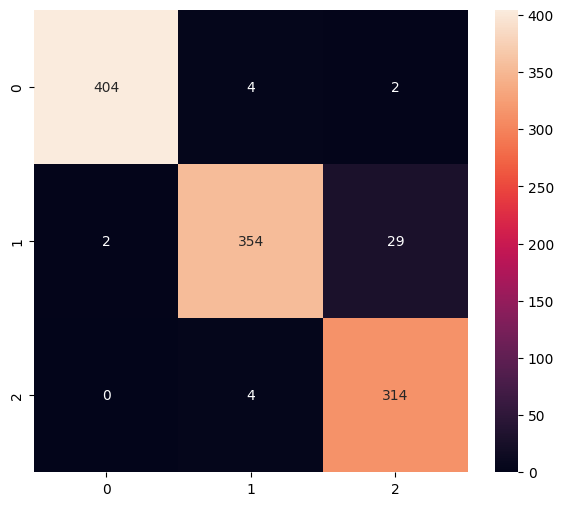

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       410
           1       0.98      0.92      0.95       385
           2       0.91      0.99      0.95       318

    accuracy                           0.96      1113
   macro avg       0.96      0.96      0.96      1113
weighted avg       0.96      0.96      0.96      1113



In [20]:
!pip3 install pandas
!pip3 install seaborn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [21]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)


/Users/siddharthfampay/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'



converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/ss/bt959stj7bd243dv8rlpvxb80000gn/T/tmplj5smzor/assets


INFO:tensorflow:Assets written to: /var/folders/ss/bt959stj7bd243dv8rlpvxb80000gn/T/tmplj5smzor/assets
2024-03-12 09:13:58.979330: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-03-12 09:13:58.979345: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


6500

# 推論テスト

In [23]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [24]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [25]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [26]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 279 µs, sys: 344 µs, total: 623 µs
Wall time: 304 µs


In [27]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.7729778  0.16973579 0.05728643]
0
